#**[A4-004] 딥러닝 코딩 실습**
#**Lecture 01: Auto-Encoders**


# **[Preliminary]** Load Packages for PyTorch & GPU Setup

In [1]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib as mpl

c:\Users\cau\miniconda3\envs\het\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **[Dataset]** Data Load for Training & Test

 **MNIST**: The MNIST database of **handwritten digits (0~9)**, 28x28 images

- **Training set:** 60,000 examples
- **Test set:** 10,000 examples

http://yann.lecun.com/exdb/mnist/


In [2]:
# mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
# mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
# mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

# MNIST Dataset 
mnist_train = torchvision.datasets.MNIST(root='./', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST(root='./', train=False, transform=transforms.ToTensor())
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

# Data Loader (with batch size)
dataloaders = {}
dataloaders['train'] = DataLoader(dataset=mnist_train, batch_size=128, shuffle=True)
dataloaders['val'] = DataLoader(dataset=mnist_val,   batch_size=128, shuffle=False)
dataloaders['test'] = DataLoader(dataset=mnist_test,  batch_size=128, shuffle=False)

# **Part I: Auto-Encoders for Image Reconstruction**

## 1-1) Define Auto-Encoder Model

In [3]:
# Define the AE model for Image Reconstruction
# Example: 784(=28x28) -> 256 -> 64 -> 256 -> 784(=28x28)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        # 1. Encoder part (= Architecutre of MLP or CNN)
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),    
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU()
        )
        # 2. Decoder part
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )
                
    def forward(self, x):           # x: (batch_size, 1, 28, 28)
        batch_size = x.size(0)      
        x = x.view(-1, 28*28)       # reshape to 784(28*28)-dimensional vector
        latent_f = self.encoder(x)  # latent feature
        out_recon = self.decoder(latent_f).view(batch_size, 1, 28, 28)  # final output. resize to input's size
        
        return out_recon, latent_f

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Autoencoder().to(device)

cuda:0


## 1-2) Define Optimizer & Loss

In [5]:
# Define Optimizer & Loss

lr = 0.0002

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss() # Reconstruction loss

## 1-3) Train the Model

In [6]:
# Define Function for Training

import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    train_loss_history = []
    val_loss_history   = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = math.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Set model to training mode
            else:
                model.eval()    # Set model to evaluate mode

            running_loss = 0.0
            

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                
                optimizer.zero_grad()

                # Forward                
                with torch.set_grad_enabled(phase == 'train'):
                    out_recon, latent_f = model(inputs)
                    loss = criterion(out_recon, inputs)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            

            # Copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)

            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training Time {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Loss: {:.4f}'.format(best_val_loss))

    # Load the weights of the best model
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [7]:
# Train the Model

epochs = 15

best_model, train_loss_history, val_loss_history = train_model(model, dataloaders, criterion, optimizer, num_epochs=epochs)

Epoch 0/14
----------
train Loss: 0.0747
val Loss: 0.0438

Epoch 1/14
----------
train Loss: 0.0369
val Loss: 0.0307

Epoch 2/14
----------
train Loss: 0.0270
val Loss: 0.0237

Epoch 3/14
----------
train Loss: 0.0215
val Loss: 0.0197

Epoch 4/14
----------
train Loss: 0.0185
val Loss: 0.0173

Epoch 5/14
----------
train Loss: 0.0164
val Loss: 0.0154

Epoch 6/14
----------
train Loss: 0.0147
val Loss: 0.0139

Epoch 7/14
----------
train Loss: 0.0133
val Loss: 0.0126

Epoch 8/14
----------
train Loss: 0.0122
val Loss: 0.0117

Epoch 9/14
----------
train Loss: 0.0113
val Loss: 0.0110

Epoch 10/14
----------
train Loss: 0.0106
val Loss: 0.0103

Epoch 11/14
----------
train Loss: 0.0100
val Loss: 0.0098

Epoch 12/14
----------
train Loss: 0.0096
val Loss: 0.0095

Epoch 13/14
----------
train Loss: 0.0091
val Loss: 0.0090

Epoch 14/14
----------
train Loss: 0.0088
val Loss: 0.0086

Training Time 1m 26s
Best Validation Loss: 0.0086


## 1-4) Plot Loss at Training & Validation

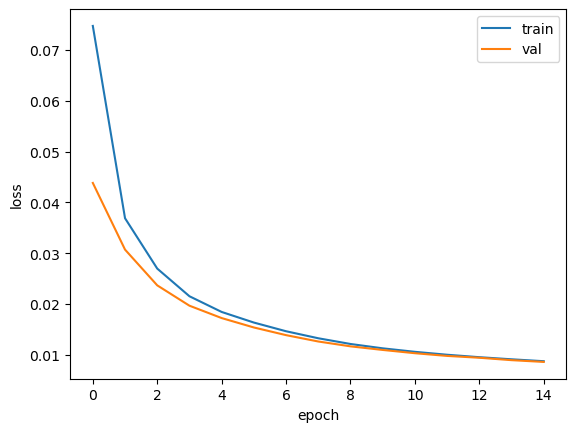

In [8]:
# Graph for Loss
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()
plt.show()

## 1-5) Check Loss at Test

In [9]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)

        out_recon, latent_f = best_model(inputs)
        test_loss = criterion(out_recon, inputs)
        
        running_loss += test_loss.item() * inputs.size(0)

    test_loss = running_loss / len(dataloaders["test"].dataset)
    print('Test Loss: {:.4f}'.format(test_loss))        

Test Loss: 0.0083


## 1-6) Visualize the Reconstructed Image (Output)

torch.Size([10000, 28, 28])


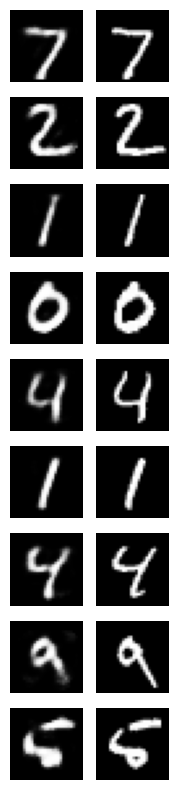

In [21]:
out_img = torch.squeeze(out_recon.cpu().data)
print(out_img.size())

plt.subplots(9, 2, figsize=(2, 8))

for i in range(1, 10):
    plt.subplot(9, 2, 2 * i)
    plt.imshow(torch.squeeze(inputs[i - 1]).cpu().numpy(),cmap='gray')
    plt.axis('off')
    plt.subplot(9, 2, 2 * i - 1)
    plt.imshow(out_img[i - 1].numpy(),cmap='gray')
    plt.axis('off')
    
plt.tight_layout()


## 1-7) Visualizing MNIST by T-SNE

In [13]:
np.random.seed(42)

from sklearn.manifold import TSNE

In [14]:
test_dataset_array = mnist_test.data.numpy() / 255
test_dataset_array = np.float32(test_dataset_array)
labels = mnist_test.targets.numpy()

In [15]:
test_dataset_array = torch.tensor(test_dataset_array)
inputs = test_dataset_array.to(device)
out_recon, latent_f = best_model(inputs)

In [16]:
latent_f = latent_f.cpu().detach().numpy()
tsne = TSNE()   
X_test_2D = tsne.fit_transform(latent_f)
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

c:\Users\cau\miniconda3\envs\het\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\cau\miniconda3\envs\het\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


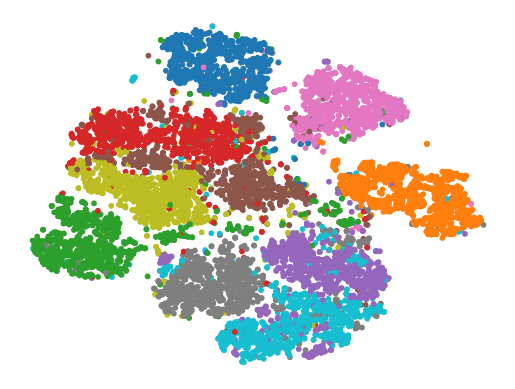

In [17]:
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap="tab10")
plt.axis("off")
plt.show()

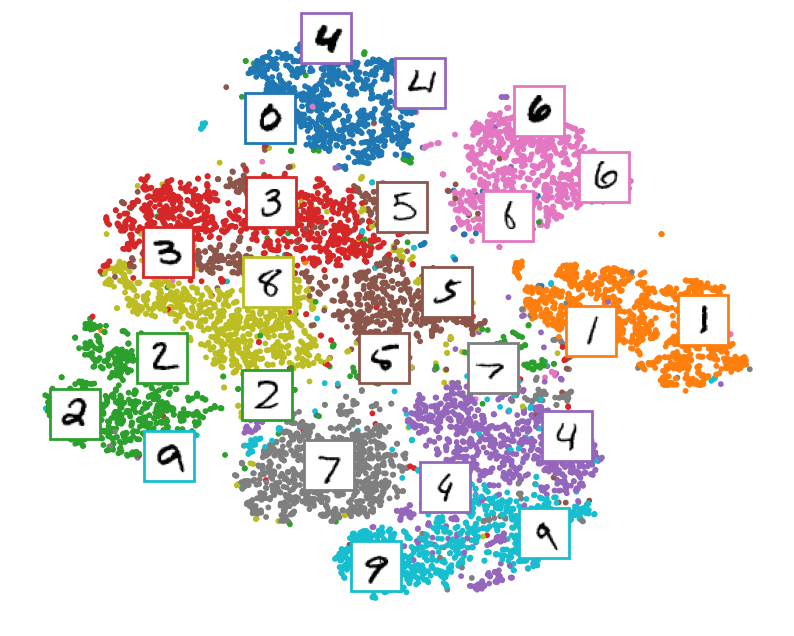

In [18]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])

for index, position in enumerate(X_test_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)

    if np.min(dist) > 0.02:
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(torch.squeeze(inputs).cpu().numpy()[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()